In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using Revise
using LinearAlgebra
using Distributions
using Random
using StatsPlots
using PDMats
using StatsBase
using Base.Iterators
using DataFrames, TimeSeries, XLSX
using PrettyTables

In [3]:
includet("../VARs/utils.jl")
includet("../VARs/VAR_OLS.jl")

In [7]:
df = DataFrame(XLSX.readtable("../../data/usa_macro_data.xlsx", "Quarterly", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :observation_date), Dates.year, first)

72×9 TimeArray{Float64, 2, Date, Matrix{Float64}} 1953-04-01 to 2024-01-01
┌────────────┬─────────────────┬─────────┬───────┬──────┬───────────┬───────────
│            │ A939RX0Q048SBEA │ GDPDEF  │ TB3MS │ GS10 │ Price_10Y │ Stock_Pr ⋯
├────────────┼─────────────────┼─────────┼───────┼──────┼───────────┼───────────
│ 1953-04-01 │         18341.0 │   13.42 │  2.15 │  3.0 │   103.357 │       24 ⋯
│ 1954-01-01 │         17636.0 │  13.544 │  1.06 │ 2.44 │    110.23 │       26 ⋯
│ 1955-01-01 │         18396.0 │  13.675 │  1.22 │ 2.65 │   111.433 │       36 ⋯
│ 1956-01-01 │         18658.0 │  14.104 │  2.33 │  2.9 │   112.895 │       44 ⋯
│ 1957-01-01 │         18881.0 │  14.621 │   3.1 │  3.4 │   112.455 │       43 ⋯
│ 1958-01-01 │         18032.0 │  14.982 │  1.76 │ 3.04 │   117.098 │       41 ⋯
│ 1959-01-01 │         19041.0 │  15.224 │  2.77 │ 3.99 │   112.898 │       54 ⋯
│ 1960-01-01 │         19614.0 │  15.428 │  3.87 │ 4.49 │   111.742 │       55 ⋯
│     ⋮      │        ⋮        │  

In [36]:
freq = 1

cpi = percentchange(data_source[:GDPDEF], :log) .* 100
gdp = percentchange(data_source[:A939RX0Q048SBEA], :log) .* 100
sr = log1p.(data_source[:TB3MS] ./ freq) .- cpi
term = log1p.(data_source[:GS10] ./ freq) .- sr
Δd = round.(percentchange(data_source[:Dividend], :log) .* 100, digits=2) .- cpi

dy = round.((log.(data_source[:Dividend]) .- log.(data_source[:Stock_Price])), digits=2)

data= merge(gdp, cpi, sr, term, Δd, dy)

start = Date(1985, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data, start),end_d)

display(returns_summarystats(s_data, freq)) 
display(cor(values(s_data)))



,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
A939RX0Q048SBEA,1.54,3.58,1.7246,3.0028,-4.1876,-1.6545,0.981,0.3009,4.3411,1.1199,1.7824
GDPDEF,1.1531,6.7639,2.3429,2.5714,0.5552,1.7489,1.8625,0.5675,4.2844,2.0318,2.0163
TB3MS_GDPDEF,1.1662,0.6921,-1.1457,-0.5314,-6.4938,-2.4802,-1.5679,0.5524,9.4386,-0.9824,-1.0348
GS10_TB3MS_GDPDEF,1.0888,7.5722,2.8226,3.2084,1.1934,2.1841,2.1611,0.4726,7.3978,2.5925,2.7061
Dividend_GDPDEF,6.3915,14.4243,3.3838,7.4514,-23.0452,-1.6696,0.7085,0.4432,5.5506,0.5294,3.648
Dividend_Stock_Price,0.3321,-3.17,-3.8705,-3.5925,-4.42,0.3718,-4.1,0.7846,-0.8387,-11.6556,-3.925


nothing

6×6 Matrix{Float64}:
  1.0          0.186541    0.00626509   0.0896323   0.163217   -0.180486
  0.186541     1.0        -0.785958     0.922917    0.108673    0.0916719
  0.00626509  -0.785958    1.0         -0.926989   -0.090758    0.0984599
  0.0896323    0.922917   -0.926989     1.0         0.041303    0.0969498
  0.163217     0.108673   -0.090758     0.041303    1.0         0.0636524
 -0.180486     0.0916719   0.0984599    0.0969498   0.0636524   1.0

In [27]:
s_data

70×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1955-01-01 to 2024-01-01
┌────────────┬─────────────────┬──────────┬──────────────┬───────────────────┬──
│            │ A939RX0Q048SBEA │ GDPDEF   │ TB3MS_GDPDEF │ GS10_TB3MS_GDPDEF │ ⋯
├────────────┼─────────────────┼──────────┼──────────────┼───────────────────┼──
│ 1955-01-01 │          4.2191 │  0.96257 │    -0.165063 │           1.45979 │ ⋯
│ 1956-01-01 │         1.41418 │  3.08891 │     -1.88594 │           3.24691 │ ⋯
│ 1957-01-01 │         1.18811 │  3.60004 │     -2.18905 │           3.67066 │ ⋯
│ 1958-01-01 │        -4.60082 │  2.43906 │     -1.42383 │           2.82008 │ ⋯
│ 1959-01-01 │         5.44466 │  1.60236 │     -0.27529 │           1.88273 │ ⋯
│ 1960-01-01 │          2.9649 │  1.33109 │     0.252003 │           1.45093 │ ⋯
│ 1961-01-01 │        -2.49858 │  1.10869 │     0.100273 │           1.46626 │ ⋯
│ 1962-01-01 │         5.70945 │  1.31187 │   0.00185362 │           1.61158 │ ⋯
│     ⋮      │        ⋮        │  

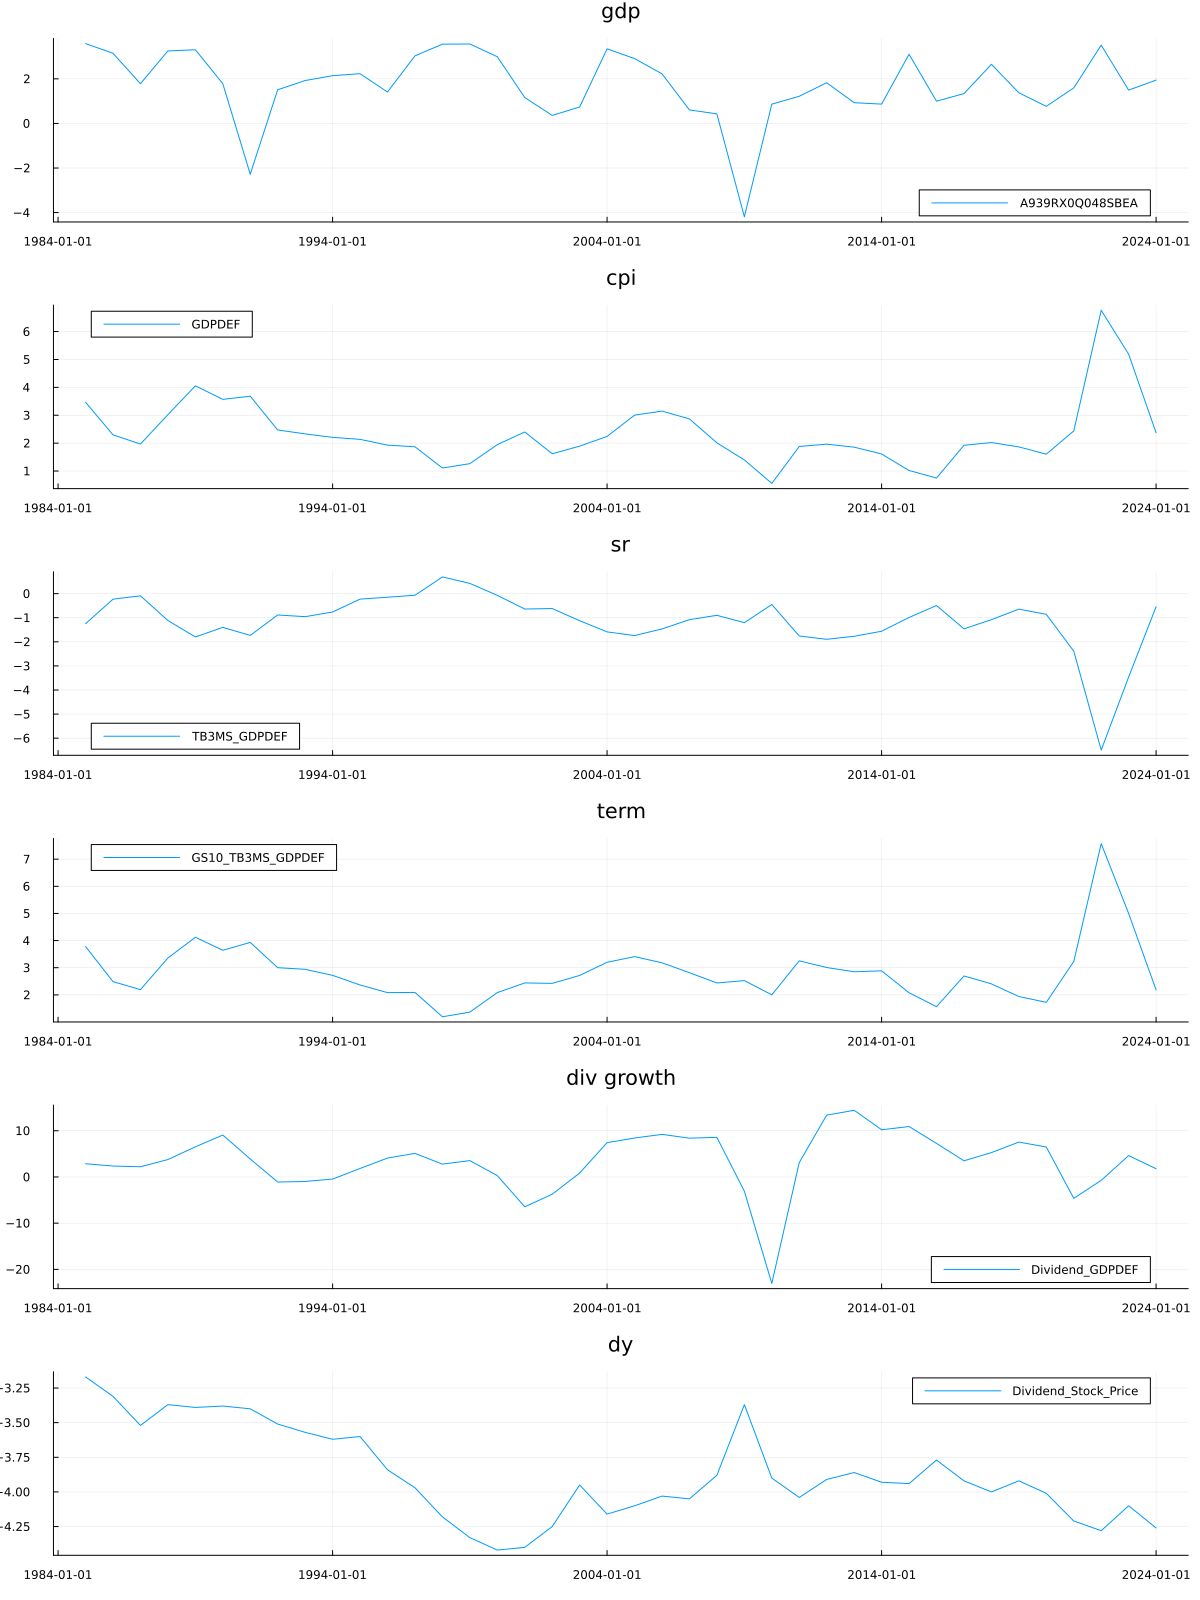

In [37]:
plot(s_data; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

In [38]:
assets_names = colnames(s_data)
T, n_assets = size(s_data)
model = VARModel(s_data)
model_summary(model)

,const,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS_GDPDEF,Dividend_GDPDEF,Dividend_Stock_Price,std
A939RX0Q048SBEA,2.2901,0.3852,-0.5235,0.0582,0.4696,-0.0444,0.3011,1.5021
GDPDEF,4.9181,0.248,0.7454,-0.9945,-1.1613,-0.058,0.6309,0.8925
TB3MS_GDPDEF,-5.0443,-0.104,-0.0578,1.7885,1.4294,0.0504,-0.534,0.9118
GS10_TB3MS_GDPDEF,5.7788,0.1197,0.1413,-1.0399,-0.7139,-0.0576,0.6478,0.9281
Dividend_GDPDEF,-20.6454,1.9042,-6.3049,2.5407,9.387,0.4808,-2.6397,4.8293
Dividend_Stock_Price,-1.6005,0.0051,-0.1057,0.1536,0.2896,0.008,0.7047,0.1612


,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS_GDPDEF,Dividend_GDPDEF,Dividend_Stock_Price
A939RX0Q048SBEA,1.0,0.14,0.02,0.04,0.09,-0.6
GDPDEF,0.14,1.0,-0.95,0.97,0.07,0.12
TB3MS_GDPDEF,0.02,-0.95,1.0,-0.98,-0.12,-0.23
GS10_TB3MS_GDPDEF,0.04,0.97,-0.98,1.0,0.07,0.19
Dividend_GDPDEF,0.09,0.07,-0.12,0.07,1.0,0.15
Dividend_Stock_Price,-0.6,0.12,-0.23,0.19,0.15,1.0


In [39]:
scenarios = simulate(model, 25*freq, 10_000)
periods = [1,5, 15, 25]
ret_in_years = cum_returns_in_periods(scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:n_assets
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS_GDPDEF,Dividend_GDPDEF,Dividend_Stock_Price
1,1.9428,2.3732,-0.5439,2.1848,1.7768,-4.26
5,1.5965,2.3654,-0.9868,2.5891,0.5628,-4.2562
15,1.5743,2.3064,-1.212,2.7334,2.4189,-4.1483
25,1.5679,2.3251,-1.2805,2.7894,2.7394,-4.109


,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS_GDPDEF,Dividend_GDPDEF,Dividend_Stock_Price
1,0.0,0.0,0.0,0.0,0.0,0.0
5,0.7188,0.6107,0.5322,0.546,3.0753,0.1418
15,0.4421,0.4442,0.4006,0.3866,2.1373,0.167
25,0.3459,0.3428,0.3213,0.3016,1.7008,0.1515


,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS_GDPDEF,Dividend_GDPDEF,Dividend_Stock_Price
1,1.0,1.0,1.0,1.0,NaN,1.0
5,0.0305,0.0307,-0.0228,0.0305,-0.0227,0.0022
15,0.0038,-0.033,-0.0027,-0.0235,0.0093,-0.0203
25,0.0045,-0.0312,0.0166,-0.0286,-0.0054,-0.0235


,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS_GDPDEF,Dividend_GDPDEF,Dividend_Stock_Price
1,-2.0,-2.0,-2.0,-2.0,NaN,-2.0
5,-0.017,0.0167,0.0418,0.0589,0.0457,0.0158
15,-0.0433,-0.0219,-0.0006,-0.0047,0.0327,-0.0018
25,-0.0391,0.0981,-0.0023,0.0321,-0.063,0.0479


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,1.9428,1.9428,1.9428,1.9428,1.9428,1.9428,1.9428,1.9428,1.9428
5,-0.0303,0.186,0.4038,1.1171,1.5953,2.0809,2.7834,3.0176,3.2844
15,0.5507,0.7069,0.8427,1.2775,1.5727,1.8757,2.3012,2.4352,2.6004
25,0.7642,0.8924,0.9984,1.3337,1.5682,1.8013,2.1431,2.2461,2.3609


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,2.3732,2.3732,2.3732,2.3732,2.3732,2.3732,2.3732,2.3732,2.3732
5,0.9477,1.1732,1.3629,1.9509,2.3661,2.772,3.3577,3.5694,3.8432
15,1.2623,1.4312,1.5634,2.0113,2.3093,2.6085,3.04,3.1726,3.3256
25,1.5343,1.6542,1.7545,2.0976,2.3283,2.5535,2.88,2.9989,3.1233


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.5439,-0.5439,-0.5439,-0.5439,-0.5439,-0.5439,-0.5439,-0.5439,-0.5439
5,-2.2214,-2.0355,-1.8675,-1.3473,-0.9838,-0.6251,-0.1202,0.0451,0.2616
15,-2.1502,-1.9944,-1.8654,-1.4814,-1.2155,-0.9425,-0.5542,-0.4252,-0.2942
25,-2.0258,-1.91,-1.8022,-1.4967,-1.2822,-1.0664,-0.7411,-0.6496,-0.5421


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,2.1848,2.1848,2.1848,2.1848,2.1848,2.1848,2.1848,2.1848,2.1848
5,1.3213,1.5166,1.7057,2.2158,2.5938,2.9573,3.4886,3.6713,3.8851
15,1.8172,1.972,2.0901,2.4757,2.7382,2.9867,3.3762,3.4863,3.5969
25,2.0802,2.1918,2.2927,2.5882,2.7947,2.9893,3.2802,3.373,3.4785


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,1.7768,1.7768,1.7768,1.7768,1.7768,1.7768,1.7768,1.7768,1.7768
5,-6.7786,-5.4965,-4.5353,-1.444,0.5495,2.6049,5.6197,6.601,7.7318
15,-2.565,-1.7238,-1.0956,0.9992,2.4106,3.8685,5.9745,6.6064,7.5143
25,-1.1827,-0.5972,-0.0673,1.5922,2.756,3.8937,5.5324,6.098,6.626


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26
5,-4.5843,-4.5336,-4.4882,-4.3515,-4.2571,-4.1606,-4.0218,-3.9772,-3.9267
15,-4.5409,-4.479,-4.4224,-4.2579,-4.1486,-4.034,-3.8756,-3.8219,-3.7625
25,-4.4652,-4.4081,-4.3625,-4.2082,-4.1096,-4.0059,-3.8637,-3.8148,-3.7536


In [41]:
display(exp(-4.2082))
display(exp(-4.1096))
display(exp(-4.0059))


0.014873115866649265

0.016414338948900157

0.018207894776967895